In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')

from data_center.binance_handler import BinanceHandHandler
from backtest.performance_generater import *
from backtest.factor_analysis_tool import FactorAnalysisTool
from backtest.operators import *

import alphalens
import quantstats as qs
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
Open = BinanceHandHandler().get_factor_data('open')
High = BinanceHandHandler().get_factor_data('high')
Low  = BinanceHandHandler().get_factor_data('low')
Close = BinanceHandHandler().get_factor_data('close')
Volume = BinanceHandHandler().get_factor_data('volume')
Volvalue = BinanceHandHandler().get_factor_data('volvalue')
Takerbuy = BinanceHandHandler().get_factor_data('takerbuy')
Takerbuyvalue = BinanceHandHandler().get_factor_data('takerbuyvalue')

returns = Close.pct_change()
expreturn = Close.pct_change().shift(-2)
Benchmark = expreturn['BTCUSDT']

In [3]:
ret_ts = returns['BTCUSDT']

In [8]:
### 將資料太短或可疑資料去除

raw_factor_list = [Open, High, Low, Close, Volume, Volvalue, Takerbuy, Takerbuyvalue, returns, expreturn]

comparison_date = pd.to_datetime('2022-01-01')

columns_to_delete = []

for raw_factor in raw_factor_list:

    # 时间戳检查：删除首个非空条目时间戳大于 comparison_date 的列
    for column in raw_factor.columns:
        if raw_factor[column].dropna().index[0] >= comparison_date:
            columns_to_delete.append(column)

    for column in raw_factor.columns:
        # 计算唯一值占比
        unique_ratio = raw_factor[column].nunique() / len(raw_factor[column])
        if unique_ratio <= 0.35:
            columns_to_delete.append(column)


columns_to_delete = list(set(columns_to_delete))
for raw_factor in raw_factor_list:
    raw_factor.drop(columns=columns_to_delete, inplace=True)

for column in raw_factor_list:
    column.dropna(inplace = True)

In [9]:
# 去除 ETF效應
for raw_factor in raw_factor_list:
    del raw_factor['BTCUSDT']
    del raw_factor['ETHUSDT']

### 從全市場獲取資料

In [26]:
def resample_dataframes(dataframes, period):
    
    resampled = {}
    for df in dataframes:
        if df is Open:
            resampled['Open'] = df.resample(period).first().dropna() 
        elif df is High:
            resampled['High'] = df.resample(period).max().dropna()
        elif df is Low:
            resampled['Low'] = df.resample(period).min().dropna()
        elif df is Close:
            resampled['Close'] = df.resample(period).last().dropna()
            resampled['returns'] = resampled['Close'].pct_change().dropna()
            resampled['expreturn'] = resampled['Close'].pct_change().shift(-2).dropna()
        elif df is Volume:
            resampled['Volume'] = df.resample(period).sum().dropna()
        elif df is Volvalue:
            resampled['Volvalue'] = df.resample(period).sum().dropna()
        elif df is Takerbuy:
            resampled['Takerbuy'] = df.resample(period).sum().dropna()
        elif df is Takerbuyvalue:
            resampled['Takerbuyvalue'] = df.resample(period).sum().dropna()
        # elif df is returns:
        #     cumulative_returns = (1 + returns).cumprod()
        #     resampled_cumulative = cumulative_returns.resample(period).last()
        #     resampled['returns']  = resampled_cumulative.pct_change()
        # elif df is expreturn:
        #     cumulative_returns = (1 + expreturn).cumprod()
        #     resampled_cumulative = cumulative_returns.resample(period).last()
        #     resampled['expreturn']  = resampled_cumulative.pct_change()
        else:
            continue
    
    return resampled

dataframe_list = [Open, High, Low, Close, Volume, Volvalue, Takerbuy, Takerbuyvalue]
period = 'd' 
resampled = resample_dataframes(dataframe_list, period)
Benchmark = resampled['expreturn']['BTCUSDT']

### Sharpe Factor

### Factor1 sharpe_21d(EXP)

In [99]:
period = 21
rolling_returns = resampled['returns'].rolling(window = period).mean()
rolling_std_dev = resampled['returns'].rolling(window = period).std()
sharpe_factor = rolling_returns / rolling_std_dev
sharpe_factor = sharpe_factor.dropna()
sharpe_returns_by_period, _ = PerformanceGenerator(factor = sharpe_factor, 
                                            expreturn = resampled['expreturn'],
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()
FactorAnalysisTool(factor = sharpe_factor, 
                                            expreturn = resampled['expreturn'],
                                            strategy = 'LS',
                                            buy_fee = 0,#0.04/100,
                                            sell_fee = 0,#0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).quantile_analysis(5)

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       327.85 %        |       156.75 %       |     1.55     |    38.33 %     |   30.58 %    |  22.64 %   | 1.43 % | 32.98 %  |
|  Benchmark  |        33.22 %        |       89.09 %        |     0.38     |     6.61 %     |   76.67 %    |  51.85 %   | 3.27 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


In [ ]:
factor = sharpe_factor
factor = factor.unstack().swaplevel(i=0, j=1)

factor_daily = factor.sort_index()

close_daily = Close.shift(-1)

# Ingest and format data
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_daily,
                                                                   close_daily,
                                                                   quantiles=5)

# Run analysis
alphalens.tears.create_full_tear_sheet(factor_data)

In [10]:
period = 21
rolling_returns = returns.rolling(window = period).mean()
rolling_std_dev = returns.rolling(window = period).std()
sharpe_factor = rolling_returns / rolling_std_dev
sharpe_factor = sharpe_factor.dropna()
sharpe_returns_by_period, _ = PerformanceGenerator(factor = sharpe_factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()
FactorAnalysisTool(factor = sharpe_factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0,#0.04/100,
                                            sell_fee = 0,#0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).quantile_analysis(5)

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       127.68 %        |       91.64 %        |     1.01     |    20.91 %     |   22.84 %    |  20.85 %   | 1.31 % | 32.74 %  |
|  Benchmark  |        27.70 %        |       81.62 %        |     0.37     |     5.80 %     |   76.67 %    |  51.28 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### Momentum Factor

In [11]:
sum_ret_factor = returns.rolling(window=20).sum().dropna()
factor = sum_ret_factor
sum_ret_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()
FactorAnalysisTool(factor = factor, 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,#.04/100,
                    sell_fee = 0,#.04/100,
                    start_time = '2020-01-01',
                    end_time = '2024-03-19',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       213.64 %        |       128.87 %       |     1.14     |    30.15 %     |   26.39 %    |  26.05 %   | 1.64 % | 30.32 %  |
|  Benchmark  |        25.29 %        |       79.73 %        |     0.36     |     5.34 %     |   76.67 %    |  51.27 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### 價量背離因子

In [12]:
pv_factor = ts_corr(returns,Volume,30)
factor = pv_factor 
pv_returns_by_period, _ = PerformanceGenerator(factor = factor , 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

FactorAnalysisTool(factor = factor , 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,
                    sell_fee = 0,
                    start_time = '2020-01-01',
                    end_time = '2024-03-19',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |        86.78 %        |       71.13 %        |     0.81     |    15.19 %     |   23.56 %    |  19.87 %   | 1.25 % | 22.08 %  |
|  Benchmark  |        35.45 %        |       88.69 %        |     0.39     |     7.11 %     |   76.67 %    |  51.32 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### Factor_bias

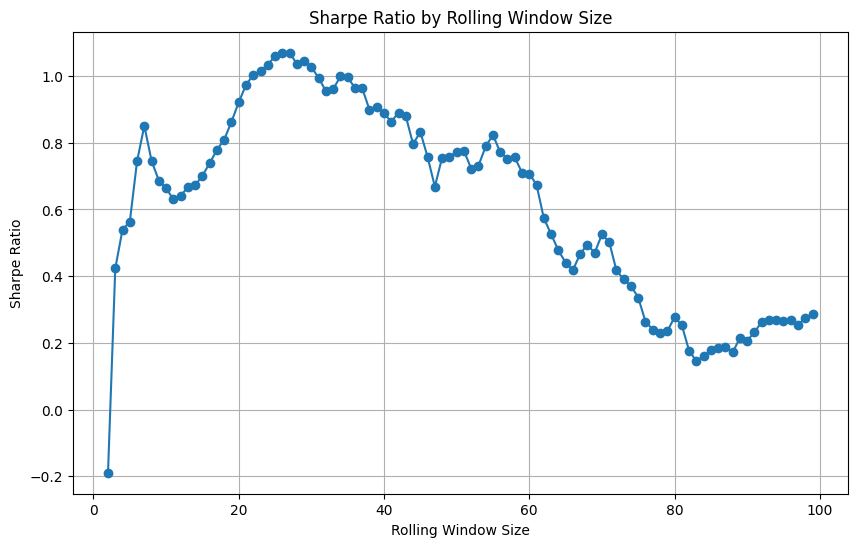

In [10]:
import matplotlib.pyplot as plt

# 窗口大小范围
window_sizes = range(2, 100)
sharpe_ratios = []

for d in window_sizes:
    # 计算乖离率指标
    bias_factor = ts_bias(df=Close, d=d, method='sma')
    factor = bias_factor.dropna()
    
    # 进行回测
    returns_by_period= PerformanceGenerator(factor=factor, 
                                                expreturn=expreturn,
                                                strategy='LS',
                                                buy_fee=0.04/100,
                                                sell_fee=0.04/100,
                                                start_time='2020-01-01',
                                                end_time='2024-03-19',
                                                period_of_year=365,
                                                benchmark=Benchmark).get_returns_by_period()
    
    # 计算Sharpe比率
    sharpe_ratio = get_sharpe(returns_by_period, 365)
    sharpe_ratios.append(sharpe_ratio)

# 绘制高原图
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, sharpe_ratios, marker='o')
plt.title('Sharpe Ratio by Rolling Window Size')
plt.xlabel('Rolling Window Size')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

In [13]:
bias_factor = ts_bias(df = Close, d = 27, method='sma')
factor = bias_factor 
bias_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

FactorAnalysisTool(factor = factor, 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,
                    sell_fee = 0,
                    start_time = '2020-01-01',
                    end_time = '2024-03-19',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       156.83 %        |       112.62 %       |     0.88     |    23.81 %     |   29.17 %    |  29.04 %   | 1.83 % | 31.06 %  |
|  Benchmark  |        35.45 %        |       88.69 %        |     0.39     |     7.11 %     |   76.67 %    |  51.32 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### factor CMO

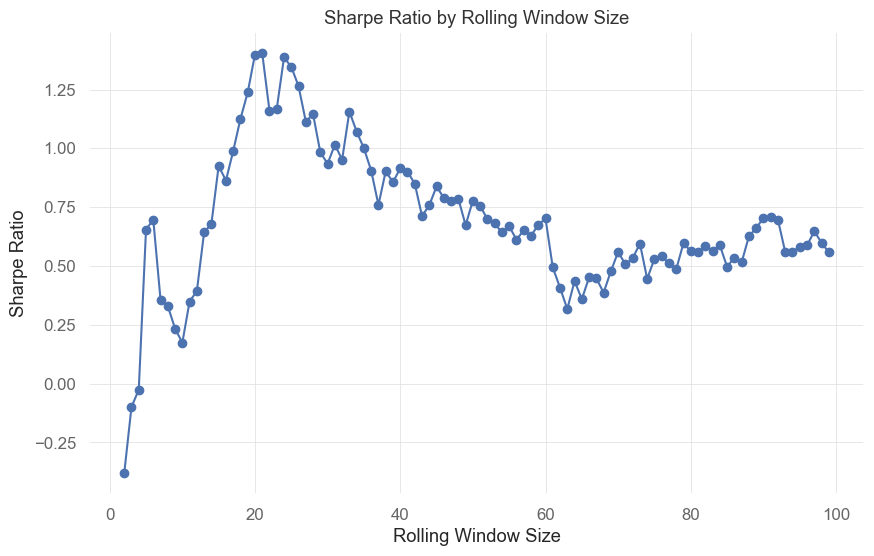

In [14]:
import matplotlib.pyplot as plt

# 窗口大小范围
window_sizes = range(2, 100)
sharpe_ratios = []

for d in window_sizes:
    # 计算乖离率指标
    cmo_factor = ts_cmo(df=Close, d=d)
    factor = cmo_factor.dropna()
    
    # 进行回测
    returns_by_period= PerformanceGenerator(factor=factor, 
                                                expreturn=expreturn,
                                                strategy='LS',
                                                buy_fee=0.04/100,
                                                sell_fee=0.04/100,
                                                start_time='2020-01-01',
                                                end_time='2024-03-19',
                                                period_of_year=365,
                                                benchmark=Benchmark).get_returns_by_period()
    
    # 计算Sharpe比率
    sharpe_ratio = get_sharpe(returns_by_period, 365)
    sharpe_ratios.append(sharpe_ratio)

# 绘制高原图
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, sharpe_ratios, marker='o')
plt.title('Sharpe Ratio by Rolling Window Size')
plt.xlabel('Rolling Window Size')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

In [15]:
cmo_factor = ts_cmo(Close, 20)
factor = cmo_factor.dropna() 
cmo_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

FactorAnalysisTool(factor = factor, 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,
                    sell_fee = 0,
                    start_time = '2020-01-01',
                    end_time = '2024-03-19',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       174.78 %        |       111.61 %       |     1.16     |    26.24 %     |   22.36 %    |  22.14 %   | 1.39 % | 34.42 %  |
|  Benchmark  |        25.29 %        |       79.73 %        |     0.36     |     5.34 %     |   76.67 %    |  51.27 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### Factor COPP

In [27]:
copp_factor = ts_copp(Close, roc1_period=15, roc2_period=15, wma_period=15)
factor = copp_factor.dropna()

# 进行回测，这里假设 PerformanceGenerator 和 get_returns_by_period 已经定义
copp_returns_by_period, _ = PerformanceGenerator(factor=factor, 
                                            expreturn=expreturn,
                                            strategy='LS',
                                            buy_fee=0.04/100,
                                            sell_fee=0.04/100,
                                            start_time='2020-01-01',
                                            end_time='2024-03-19',
                                            period_of_year=365,
                                            benchmark=Benchmark).backtest()

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       115.75 %        |       88.73 %        |     0.87     |    19.57 %     |   23.47 %    |  23.59 %   | 1.49 % | 12.41 %  |
|  Benchmark  |        11.03 %        |       67.30 %        |     0.30     |     2.46 %     |   76.67 %    |  51.32 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


### 大盤相關因子

In [26]:
BTCasMarket = pd.DataFrame()# (index=Returns.index, columns=Returns.columns)
# Loop to repeat the concatenation process
for i in returns.columns.to_list():
    BTCasMarket = pd.concat([BTCasMarket, Market.rename(i)], axis=1)
BTCasMarket

BNBUSDT  AAVEUSDT  AVAXUSDT   ETCUSDT   SOLUSDT   ADAUSDT  \
2019-09-08       NaN       NaN       NaN       NaN       NaN       NaN   
2019-09-09       NaN       NaN       NaN       NaN       NaN       NaN   
2019-09-10 -0.019887 -0.019887 -0.019887 -0.019887 -0.019887 -0.019887   
2019-09-11  0.005695  0.005695  0.005695  0.005695  0.005695  0.005695   
2019-09-12  0.025157  0.025157  0.025157  0.025157  0.025157  0.025157   
...              ...       ...       ...       ...       ...       ...   
2024-03-22 -0.026150 -0.026150 -0.026150 -0.026150 -0.026150 -0.026150   
2024-03-23  0.003044  0.003044  0.003044  0.003044  0.003044  0.003044   
2024-03-24  0.050618  0.050618  0.050618  0.050618  0.050618  0.050618   
2024-03-25  0.039542  0.039542  0.039542  0.039542  0.039542  0.039542   
2024-03-26  0.001768  0.001768  0.001768  0.001768  0.001768  0.001768   

            LINKUSDT   BCHUSDT   DOTUSDT   LTCUSDT   UNIUSDT   XRPUSDT  \
2019-09-08       NaN       NaN       NaN       NaN       NaN       NaN   
2019-09-09       NaN       NaN       NaN       NaN       NaN       NaN   
2019-09-10 -0.019887 -0.019887 -0.019887 -0.019887 -0.019887 -0.019887   
2019-09-11  0.005695  0.005695  0.005695  0.005695  0.005695  0.005695   
2019-09-12  0.025157  0.025157  0.025157  0.025157  0.025157  0.025157   
...              ...       ...       ...       ...       ...       ...   
2024-03-22 -0.026150 -0.026150 -0.026150 -0.026150 -0.026150 -0.026150   
2024-03-23  0.003044  0.003044  0.003044  0.003044  0.003044  0.003044   
2024-03-24  0.050618  0.050618  0.050618  0.050618  0.050618  0.050618   
2024-03-25  0.039542  0.039542  0.039542  0.039542  0.039542  0.039542   
2024-03-26  0.001768  0.001768  0.001768  0.001768  0.001768  0.001768   

             XLMUSDT  MATICUSDT   TRXUSDT  DOGEUSDT  DASHUSDT   ZECUSDT  
2019-09-08       NaN        NaN       NaN       NaN       NaN       NaN  
2019-09-09       NaN        NaN       NaN       NaN       NaN       NaN  
2019-09-10 -0.019887  -0.019887 -0.019887 -0.019887 -0.019887 -0.019887  
2019-09-11  0.005695   0.005695  0.005695  0.005695  0.005695  0.005695  
2019-09-12  0.025157   0.025157  0.025157  0.025157  0.025157  0.025157  
...              ...        ...       ...       ...       ...       ...  
2024-03-22 -0.026150  -0.026150 -0.026150 -0.026150 -0.026150 -0.026150  
2024-03-23  0.003044   0.003044  0.003044  0.003044  0.003044  0.003044  
2024-03-24  0.050618   0.050618  0.050618  0.050618  0.050618  0.050618  
2024-03-25  0.039542   0.039542  0.039542  0.039542  0.039542  0.039542  
2024-03-26  0.001768   0.001768  0.001768  0.001768  0.001768  0.001768  

[1662 rows x 18 columns]

In [17]:
df = pd.concat([sharpe_returns_by_period, sum_ret_returns_by_period, pv_returns_by_period, bias_returns_by_period, cmo_returns_by_period, copp_returns_by_period, Benchmark], axis=1).dropna()
df.columns = ['sharpe', 'sum_ret', 'PV', 'bias', 'cmo', 'copp', 'BTC']

# 计算相关系数
correlation_matrix = df.corr()

print(correlation_matrix)

           sharpe   sum_ret        PV      bias       cmo      copp       BTC
sharpe   1.000000  0.894837  0.582174  0.836353  0.945553  0.694401 -0.035779
sum_ret  0.894837  1.000000  0.655006  0.927464  0.912994  0.722097 -0.016136
PV       0.582174  0.655006  1.000000  0.658381  0.666455  0.432541 -0.004356
bias     0.836353  0.927464  0.658381  1.000000  0.893206  0.523430 -0.062670
cmo      0.945553  0.912994  0.666455  0.893206  1.000000  0.601650 -0.050998
copp     0.694401  0.722097  0.432541  0.523430  0.601650  1.000000 -0.001527
BTC     -0.035779 -0.016136 -0.004356 -0.062670 -0.050998 -0.001527  1.000000


In [35]:
Multi_alpha.dropna()

BNBUSDT   AAVEUSDT   AVAXUSDT    ETCUSDT    SOLUSDT    ADAUSDT  \
datetime                                                                       
2021-03-29  -2.568795 -28.780558 -11.216258   8.391743  57.278371   4.447820   
2021-03-30  35.879381  -8.273679   1.019945  19.845047  62.657060  11.369047   
2021-03-31  21.047783  -4.824279  -8.615688  35.236115  54.944319   8.236379   
2021-04-01  58.775448   5.060645  -3.903500  40.828458  62.191916  14.984005   
2021-04-02  54.942190  14.483264  -8.635286  39.331815  65.559537  10.687748   
...               ...        ...        ...        ...        ...        ...   
2024-03-25  52.986019  20.027122  50.474072  -8.819533  57.636692 -11.801058   
2024-03-26  43.756067   8.712353  37.772938 -24.693033  55.055272 -17.894375   
2024-03-27  32.534469  -7.811817  27.216710 -30.208366  41.786075 -24.875315   
2024-03-28  32.525761  -2.138381  29.405666 -25.399462  43.407464 -20.146899   
2024-03-29  40.594290  -1.977997  22.917844 -10.152356  44.653532 -19.037396   

             LINKUSDT    BCHUSDT    DOTUSDT    LTCUSDT    UNIUSDT    XRPUSDT  \
datetime                                                                       
2021-03-29 -17.365230  -9.608537 -16.591627  -8.792762 -19.674846  35.533890   
2021-03-30 -12.034602  -5.916039 -16.231485  -3.387523 -15.882020  40.003608   
2021-03-31   0.192963   0.761782   6.524038  -3.118286 -19.809917  45.392977   
2021-04-01  13.329279  11.388387  12.169549 -13.939447 -14.750578  49.009738   
2021-04-02  25.667951   5.471770  28.885726  -6.138136  -9.787711  57.996613   
...               ...        ...        ...        ...        ...        ...   
2024-03-25   2.273204  42.337933   3.512288  14.592321  -9.645526  11.622981   
2024-03-26   1.626302  32.223523 -12.278278  21.125698 -29.747847   4.231138   
2024-03-27  -7.436032  53.182597 -16.297740  12.262975 -33.100864  -6.210321   
2024-03-28  -6.188084  61.451636 -17.930605  12.738627 -20.647587  -0.219040   
2024-03-29 -10.224105  81.544331 -14.611024  41.792877 -19.058993   1.812913   

              XLMUSDT  MATICUSDT     TRXUSDT   DOGEUSDT   DASHUSDT    XEMUSDT  \
datetime                                                                        
2021-03-29  -9.691776  34.570027   43.594614 -14.107250 -21.670075 -76.822514   
2021-03-30  -2.802855  28.685527   52.051001  -8.740563 -14.106599 -51.547250   
2021-03-31   1.774502  -7.162173  122.051892 -10.687186  -7.058659 -47.970939   
2021-04-01  23.342649  -9.130331   92.335272  28.565400  12.687443 -24.416213   
2021-04-02  25.063742  -2.526837  103.075572 -11.839995  10.700908 -13.716087   
...               ...        ...         ...        ...        ...        ...   
2024-03-25   4.481326  -2.556440  -40.996592  23.307422  10.367734  14.245819   
2024-03-26   0.719229 -11.474736  -44.548655  27.085605   3.027096  14.072146   
2024-03-27 -10.458068 -23.532885  -46.131480  33.894930  -5.501430  -3.395065   
2024-03-28  -3.144407 -21.369052  -40.605303  58.132729  -8.612571   2.692986   
2024-03-29   3.969205 -27.196033  -40.188730  42.870647   1.887434  -2.522127   

              ZECUSDT  
datetime               
2021-03-29  16.517077  
2021-03-30  21.727176  
2021-03-31  17.653849  
2021-04-01  31.841070  
2021-04-02  28.855893  
...               ...  
2024-03-25  -2.280425  
2024-03-26  -3.734534  
2024-03-27 -14.385974  
2024-03-28 -18.743941  
2024-03-29 -17.753278  

[1097 rows x 19 columns]

In [36]:
ranked_df = Multi_alpha.dropna().rank(axis=1, pct=True)

# Replace values between 0.2 and 0.8 with NaN
filtered_df = ranked_df.where(~((ranked_df > 0.2) & (ranked_df < 0.8)), np.nan)

filtered_df

BNBUSDT  AAVEUSDT  AVAXUSDT   ETCUSDT   SOLUSDT   ADAUSDT  \
datetime                                                                 
2021-03-29       NaN  0.105263       NaN       NaN  1.000000       NaN   
2021-03-30  0.842105       NaN       NaN       NaN  1.000000       NaN   
2021-03-31       NaN       NaN       NaN  0.842105  0.947368       NaN   
2021-04-01  0.894737       NaN       NaN       NaN  0.947368       NaN   
2021-04-02  0.842105       NaN       NaN       NaN  0.947368       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-03-25  0.947368       NaN  0.894737       NaN  1.000000  0.105263   
2024-03-26  0.947368       NaN  0.894737  0.157895  1.000000       NaN   
2024-03-27  0.842105       NaN       NaN  0.157895  0.947368       NaN   
2024-03-28  0.842105       NaN       NaN  0.105263  0.894737       NaN   
2024-03-29       NaN       NaN       NaN       NaN  0.947368       NaN   

            LINKUSDT   BCHUSDT   DOTUSDT   LTCUSDT   UNIUSDT   XRPUSDT  \
datetime                                                                 
2021-03-29       NaN       NaN       NaN       NaN       NaN  0.894737   
2021-03-30       NaN       NaN  0.105263       NaN  0.157895  0.894737   
2021-03-31       NaN       NaN       NaN       NaN  0.105263  0.894737   
2021-04-01       NaN       NaN       NaN  0.157895  0.105263  0.842105   
2021-04-02       NaN       NaN       NaN       NaN  0.157895  0.894737   
...              ...       ...       ...       ...       ...       ...   
2024-03-25       NaN  0.842105       NaN       NaN  0.157895       NaN   
2024-03-26       NaN  0.842105       NaN       NaN  0.105263       NaN   
2024-03-27       NaN  1.000000       NaN       NaN  0.105263       NaN   
2024-03-28       NaN  1.000000       NaN       NaN       NaN       NaN   
2024-03-29       NaN  1.000000       NaN  0.842105  0.157895       NaN   

            XLMUSDT  MATICUSDT   TRXUSDT  DOGEUSDT  DASHUSDT   XEMUSDT  \
datetime                                                                 
2021-03-29      NaN   0.842105  0.947368       NaN  0.157895  0.052632   
2021-03-30      NaN        NaN  0.947368       NaN       NaN  0.052632   
2021-03-31      NaN        NaN  1.000000  0.157895       NaN  0.052632   
2021-04-01      NaN        NaN  1.000000       NaN       NaN  0.052632   
2021-04-02      NaN        NaN  1.000000  0.105263       NaN  0.052632   
...             ...        ...       ...       ...       ...       ...   
2024-03-25      NaN        NaN  0.052632       NaN       NaN       NaN   
2024-03-26      NaN        NaN  0.052632       NaN       NaN       NaN   
2024-03-27      NaN        NaN  0.052632  0.894737       NaN       NaN   
2024-03-28      NaN   0.157895  0.052632  0.947368       NaN       NaN   
2024-03-29      NaN   0.105263  0.052632  0.894737       NaN       NaN   

            ZECUSDT  
datetime             
2021-03-29      NaN  
2021-03-30      NaN  
2021-03-31      NaN  
2021-04-01      NaN  
2021-04-02      NaN  
...             ...  
2024-03-25      NaN  
2024-03-26      NaN  
2024-03-27      NaN  
2024-03-28      NaN  
2024-03-29      NaN  

[1097 rows x 19 columns]

In [40]:
Multi_alpha = sharpe_factor + sum_ret_factor + bias_factor + cmo_factor # + copp_factor + pv_factor
ranked_df = Multi_alpha.dropna().rank(axis=1, pct=True)

# Replace values between 0.2 and 0.8 with NaN
filtered_df = ranked_df.where(~((ranked_df > 0.2) & (ranked_df < 0.8)), np.nan)
factor = filtered_df
# Multi_alpha.dropna()
# median=Multi_alpha.median(axis = 1)
# new_alpha = Multi_alpha.sub(median,axis=0)
# factor = new_alpha.dropna()
Multi_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-29',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()
# FactorAnalysisTool(factor = factor, 
#                     expreturn = expreturn,
#                     strategy = 'LS',
#                     buy_fee = 0,
#                     sell_fee = 0,
#                     start_time = '2020-01-01',
#                     end_time = '2024-03-29',
#                     period_of_year = 365,
#                     benchmark = Benchmark
#                     ).quantile_analysis(5)

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       271.06 %        |       146.27 %       |     1.27     |    35.15 %     |   23.32 %    |  26.40 %   | 1.66 % |  5.21 %  |
|  Benchmark  |         nan %         |        nan %         |     0.33     |     nan %      |   76.67 %    |  51.18 %   | 3.22 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


In [19]:
print('BTC:', Benchmark.std())
print('Multi:', Multi_returns_by_period.std())

BTC: 0.03515343053434822
Multi: 0.015425363520903547


In [21]:
import pandas as pd
import matplotlib.pyplot as plt


# 将两个Series相加以获得总回报率
profolio_manipulate = Multi_returns_by_period*3/4 + Benchmark*1/4

# # 计算复利效果
# # 为了从回报率计算复利增长，我们将每期回报率+1，然后计算累积乘积
# compounded_growth = (1 + profolio_manipulate).cumprod().dropna()

# # 绘制复利增长曲线
# plt.figure(figsize=(10, 6))
# compounded_growth.plot()
# plt.title('Compounded Growth Over Time')
# plt.ylabel('Compounded Growth')
# plt.xlabel('Time')
# plt.grid(True)
# plt.show()
# qs.reports.full(profolio_manipulate, benchmark=Benchmark,periods_per_year=365)
summary_df = get_performance_report(profolio_manipulate, benchmark=Benchmark, period_of_year=365)


+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+
| Performance |       161.09 %        |       106.55 %       |     1.34     |    37.86 %     |   22.37 %    |  26.67 %   | 1.40 % |
|  Benchmark  |        22.35 %        |       77.22 %        |     0.42     |     6.98 %     |   76.67 %    |  61.68 %   | 3.23 % |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+


In [22]:
df = pd.concat([returns_by_period, Benchmark, profolio_manipulate], axis=1)
df.columns = ['Multi', 'BTC', 'profolio_manipulate ']

# 计算相关系数
correlation_matrix = df.corr()

print(correlation_matrix)

                         Multi       BTC  profolio_manipulate 
Multi                 1.000000 -0.014151              0.481066
BTC                  -0.014151  1.000000              0.558991
profolio_manipulate   0.481066  0.558991              1.000000


/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to n

Dropped 3.6% entries from factor data: 3.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min         max       mean        std  count  \
factor_quantile                                                        
1               -194.974968  130.728249 -40.684062  52.548775   4332   
2               -149.013206  143.899029 -18.321872  53.140454   4332   
3               -138.493140  166.922270  -4.900505  55.109259   3249   
4               -125.804578  236.302747  12.492184  59.855672   4332   
5               -107.918361  902.216256  65.977879  95.450863   4332   

                   count %  
factor_quantile             
1                21.052632  
2                21.052632  
3                15.789474  
4                21.052632  
5                21.052632

Returns Analysis


1D      5D     10D
Ann. alpha                                      0.317   0.253   0.215
beta                                            0.008   0.002   0.017
Mean Period Wise Return Top Quantile (bps)     11.677  10.536  10.790
Mean Period Wise Return Bottom Quantile (bps)  -5.901  -7.729  -7.042
Mean Period Wise Spread (bps)                  17.577  16.908  16.829

<Figure size 1000x600 with 0 Axes>

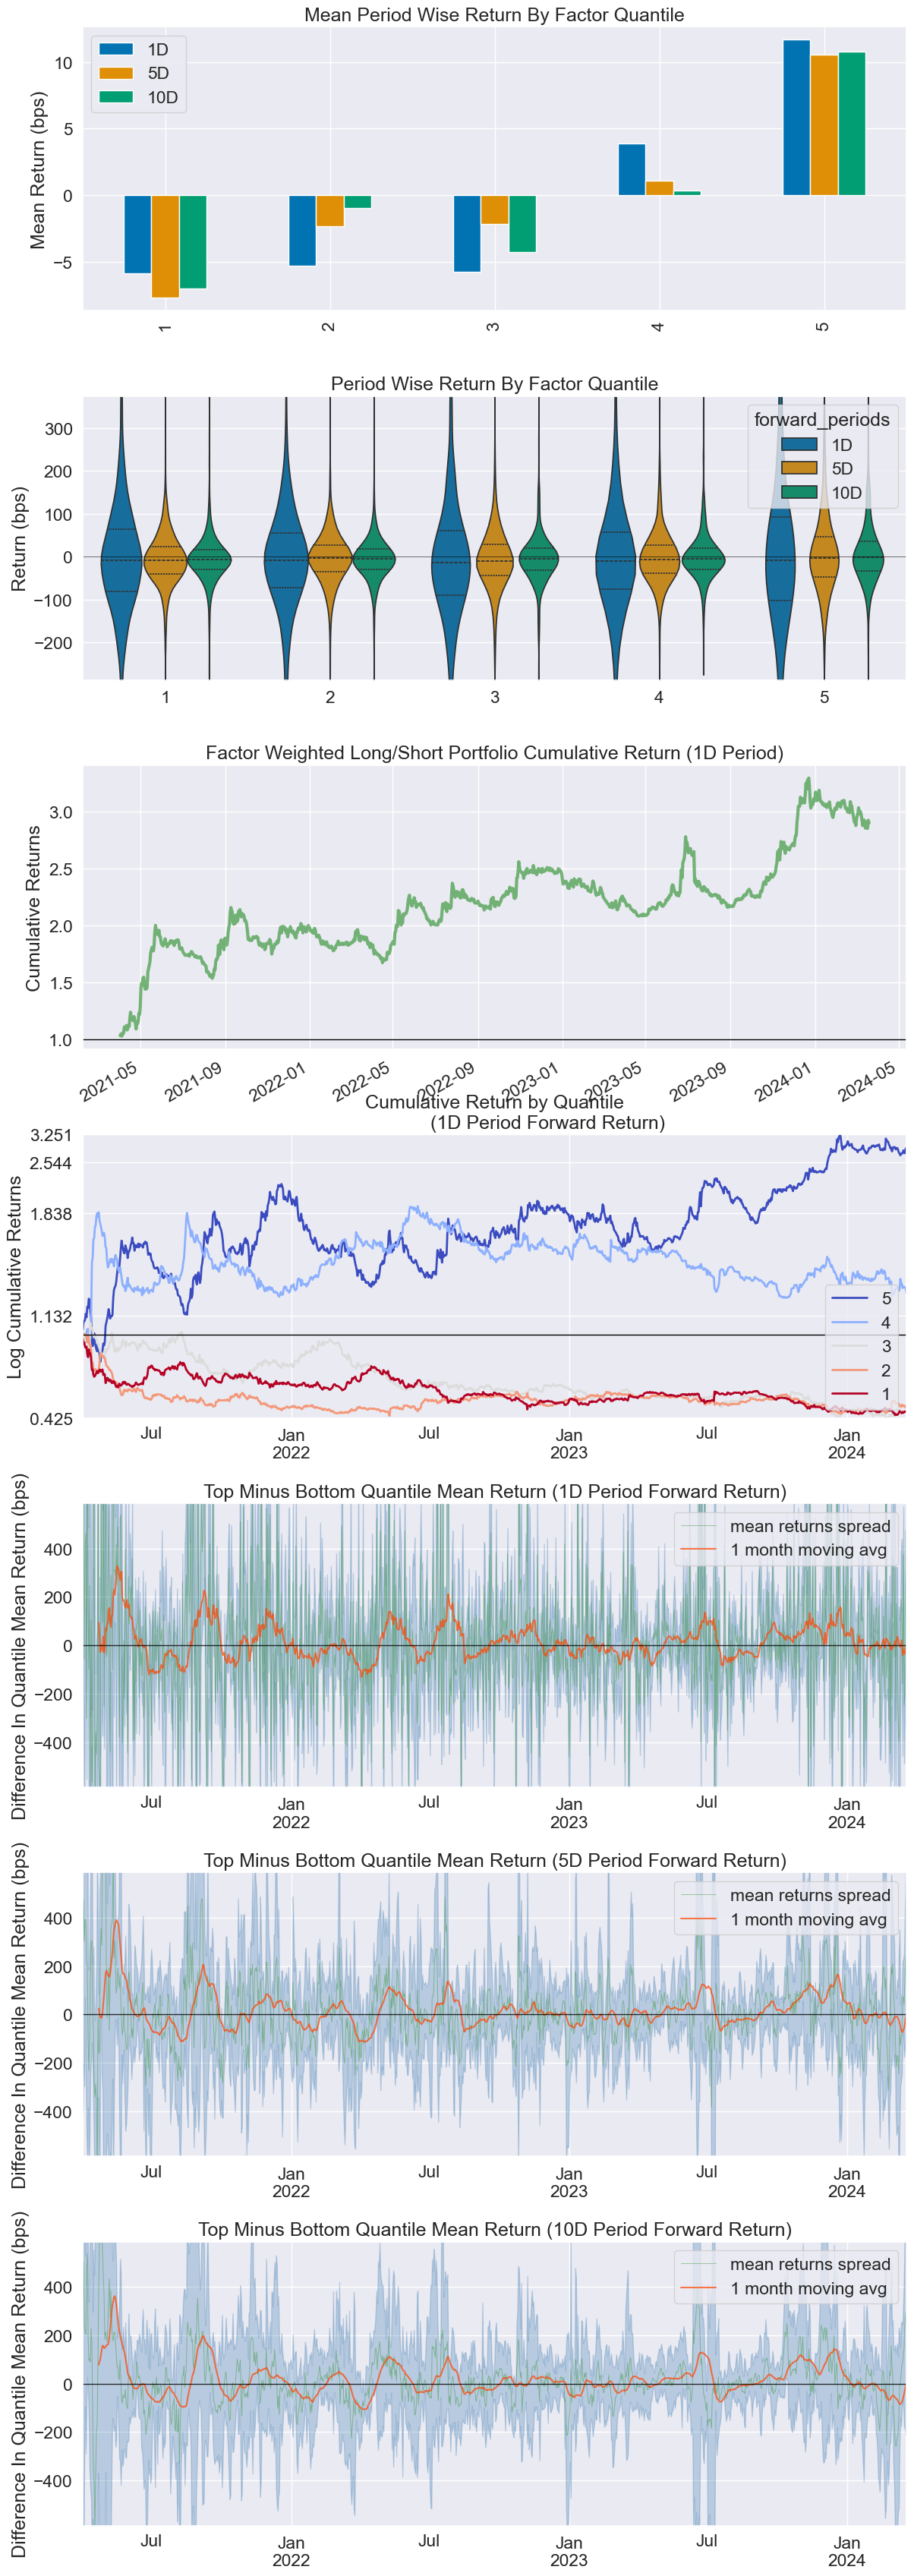

Information Analysis


1D     5D    10D
IC Mean          -0.024 -0.023 -0.009
IC Std.           0.285  0.278  0.274
Risk-Adjusted IC -0.085 -0.084 -0.032
t-stat(IC)       -2.807 -2.752 -1.052
p-value(IC)       0.005  0.006  0.293
IC Skew           0.034  0.081 -0.036
IC Kurtosis      -0.393 -0.489 -0.552

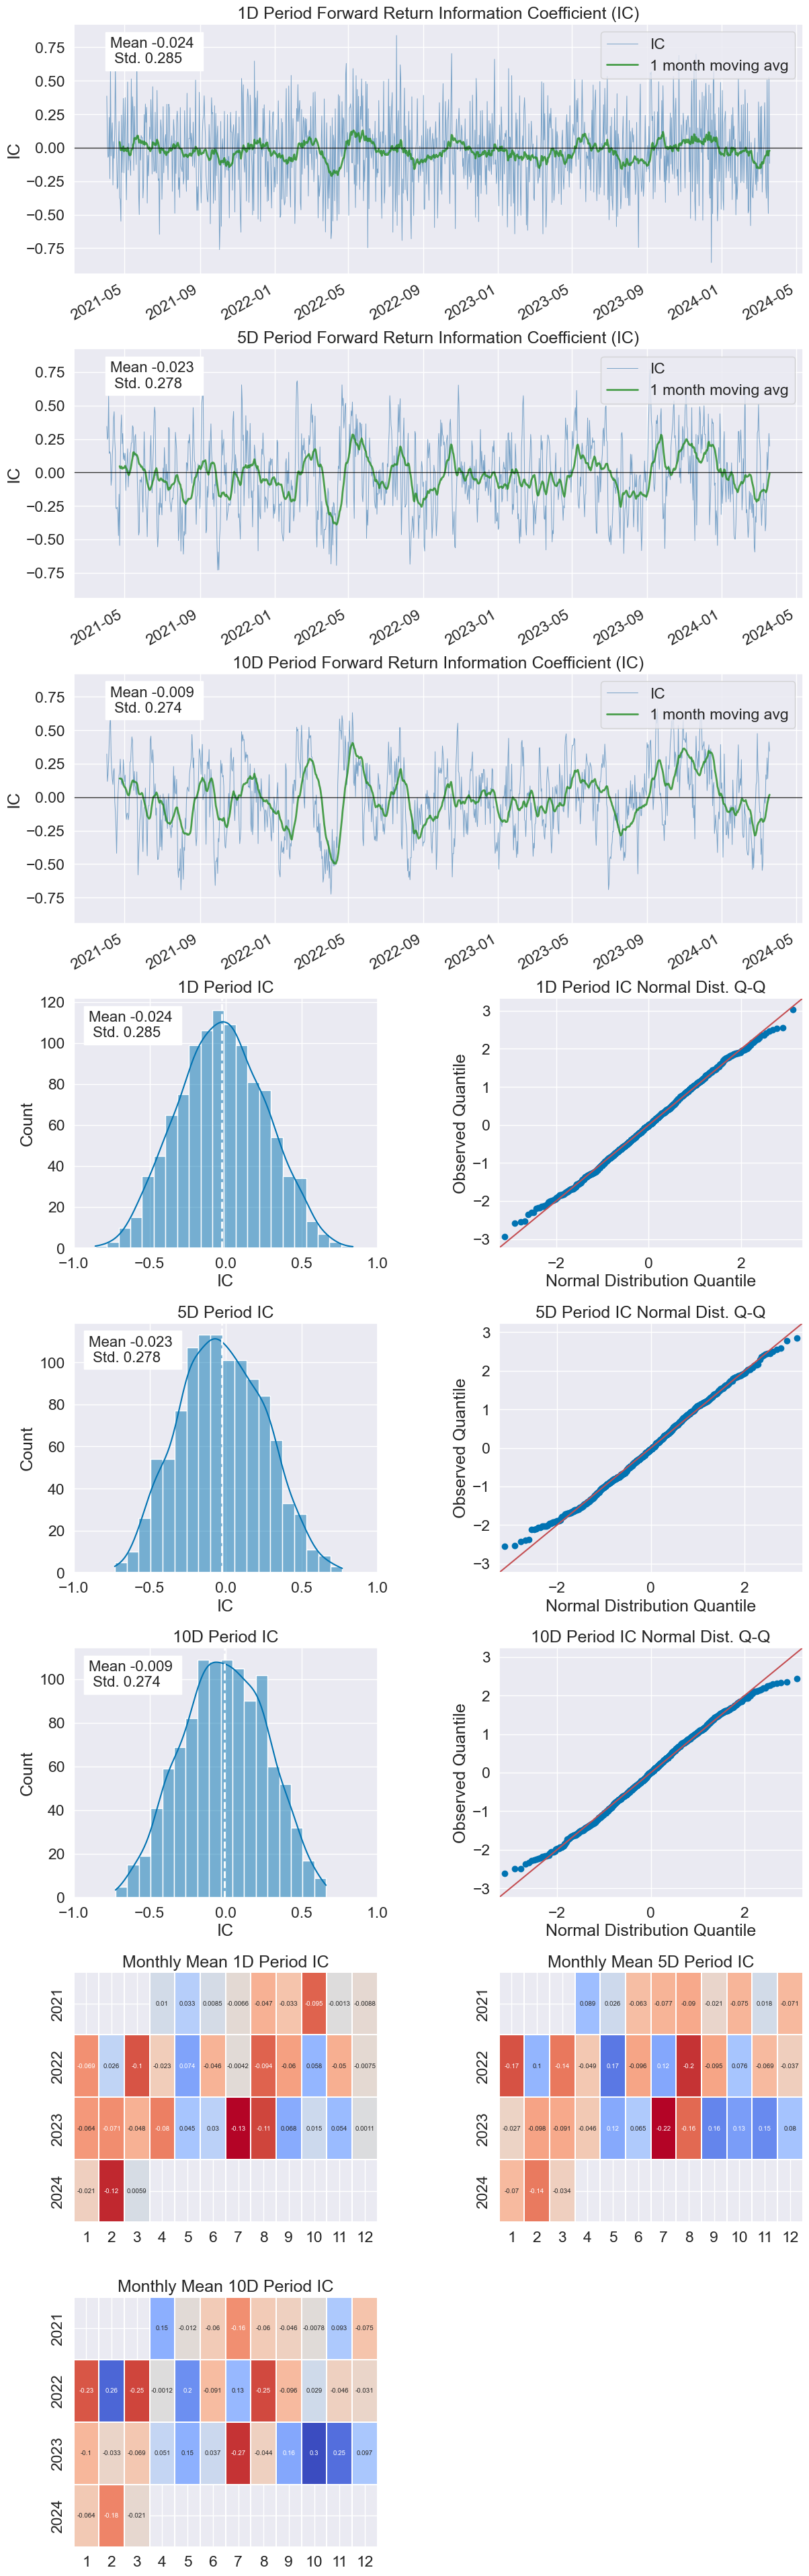

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:929: UserWarning:

Skipping return periods that aren't exact multiples of days.



Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.160  0.365  0.536
Quantile 2 Mean Turnover   0.323  0.608  0.710
Quantile 3 Mean Turnover   0.431  0.694  0.786
Quantile 4 Mean Turnover   0.276  0.547  0.681
Quantile 5 Mean Turnover   0.111  0.284  0.441

1D    5D    10D
Mean Factor Rank Autocorrelation  0.95  0.78  0.544

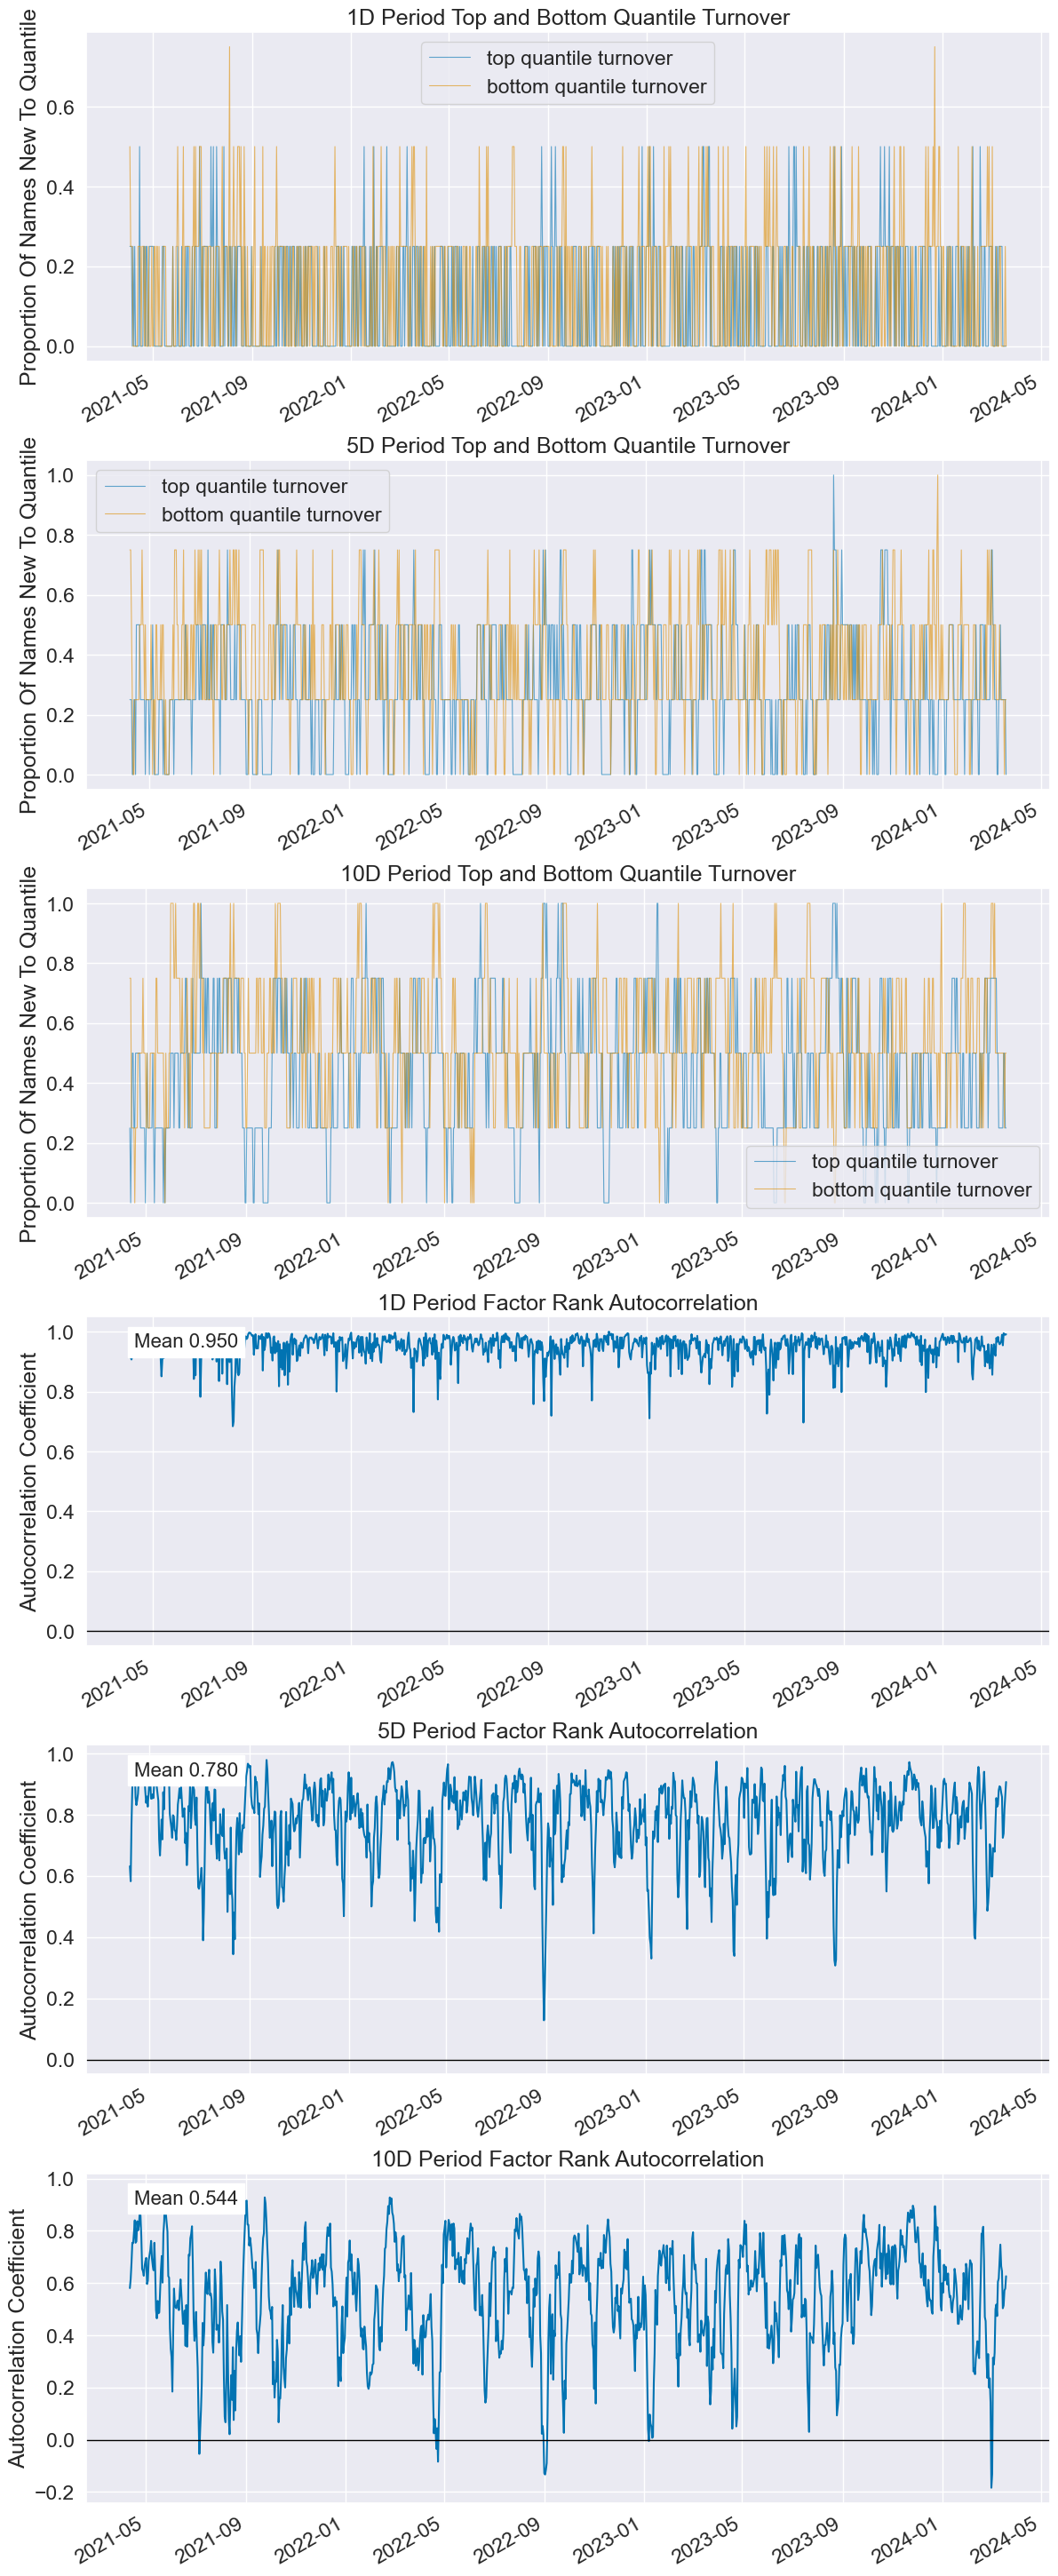

In [16]:
factor = Multi_alpha.unstack().swaplevel(i=0, j=1)

factor_daily = factor.sort_index()

close_daily = Close.shift(-1)

# Ingest and format data
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_daily,
                                                                   close_daily,
                                                                   quantiles=5)

# Run analysis
alphalens.tears.create_full_tear_sheet(factor_data)